# Make Env

made by Juhyun Kim 
Create cell lineage using slingshot to create interaction term between genotype and lineage.
1. Create cell lineage using slingshot
2. Choose one lineage to use for Dynamic eQTL analysis
3. Divide the cell into equal amounts of quantiles (for result plotting later)

In [1]:
date()

[1] "Sun Aug  7 11:14:13 2022"

In [6]:
# Arguments # 
SeuratObject <- "/mnt/gmi-analysis01/_90.User_Data/jaeyong15/singlecell/NRF_all/01.automated/01.NRFonly/40.NRFonly.n11.basal.to.sec.RDS"
final_celltype <- "final_celltype"

# Load data and R Library

In [29]:
# Seurat Object to use
sdata <- readRDS(SeuratObject)

In [5]:
suppressMessages(library(tidyverse))
suppressMessages(library(slingshot))
suppressMessages(library(Seurat))
suppressMessages(library(tradeSeq))
suppressMessages(library(S4Vectors))
suppressMessages(library(SingleCellExperiment))
suppressMessages(library(SeuratDisk))

# Exploring single cell Data by phate or Umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



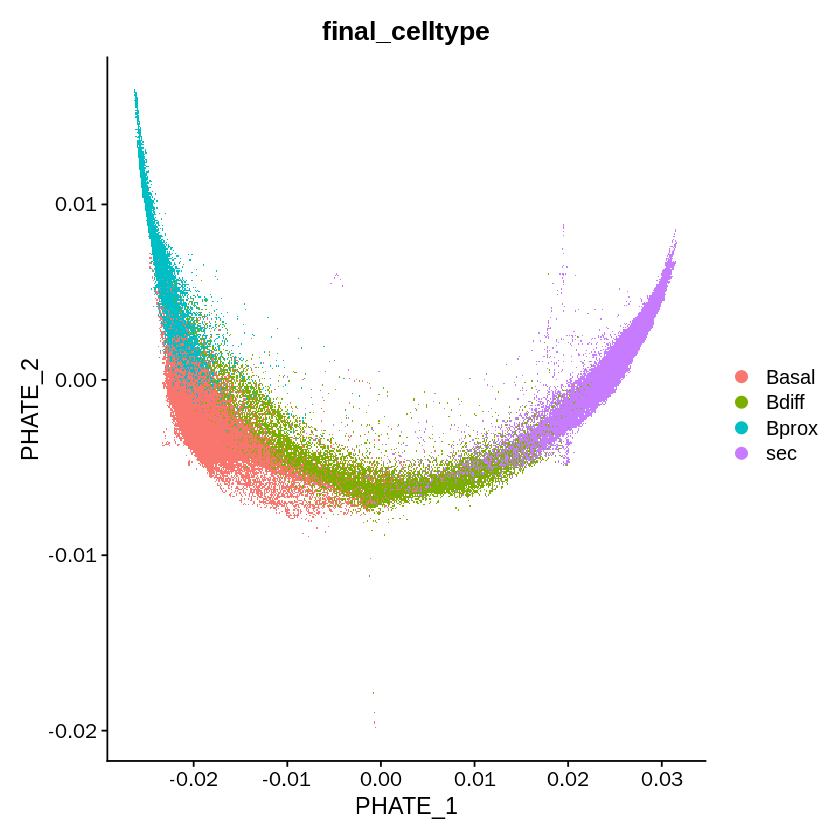

In [7]:
DimPlot(sdata, reduction = "phate", group.by = final_celltype)

In [8]:
dimred <- sdata@reductions$phate@cell.embeddings
clustering <- sdata@meta.data$RNA_snn_res.0.2

set.seed(1)
lineages <- getLineages(dimred, clustering)

In [9]:
lineages

class: PseudotimeOrdering 
dim: 135155 2 
metadata(3): lineages mst slingParams
pathStats(2): pseudotime weights
cellnames(135155): CHR0081_AAACCCACACCAGTTA-1
  CHR0081_AAACCCACACGCTGAC-1 ... CHR0109_TTTGTTGTCGACATAC-1
  CHR0109_TTTGTTGTCTTCACAT-1
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):

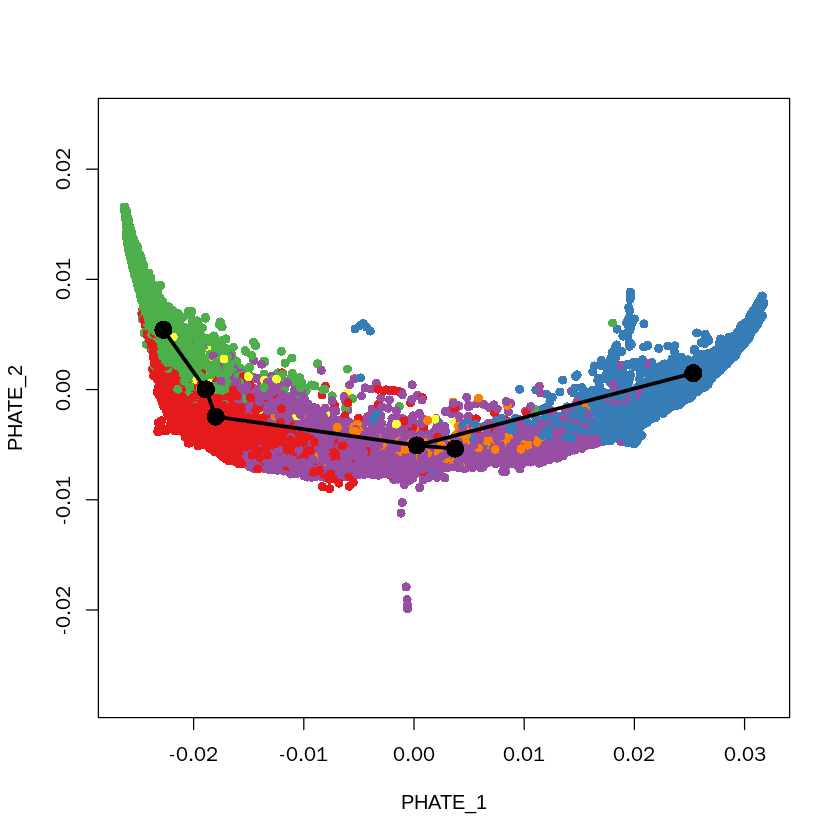

In [10]:
plot.new()
lineages <- as.SlingshotDataSet(lineages)
plot(dimred, col = RColorBrewer::brewer.pal(9,"Set1")[clustering], asp = 1, pch = 16)
lines(lineages, lwd = 3, col = 'black')

In [11]:
curves <- getCurves(lineages)
curves

class: PseudotimeOrdering 
dim: 135155 2 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(135155): CHR0081_AAACCCACACCAGTTA-1
  CHR0081_AAACCCACACGCTGAC-1 ... CHR0109_TTTGTTGTCGACATAC-1
  CHR0109_TTTGTTGTCTTCACAT-1
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):

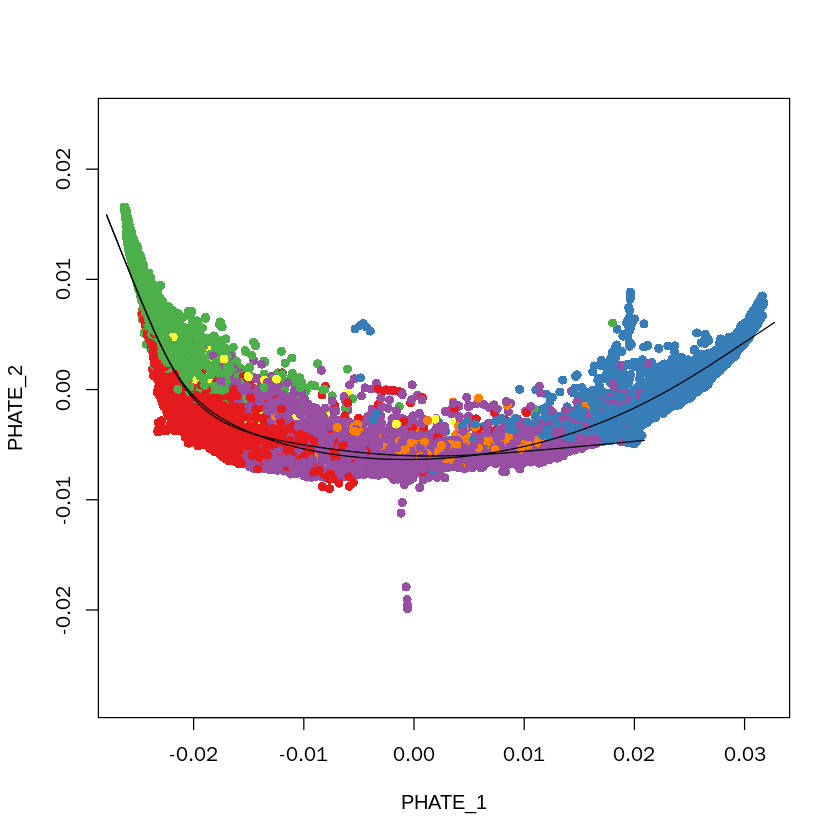

In [12]:
plot(dimred, col = RColorBrewer::brewer.pal(9,"Set1")[clustering], asp = 1, pch = 16)
lines(as.SlingshotDataSet(curves), lwd = 1, col = 'black')

In [13]:
curves

class: PseudotimeOrdering 
dim: 135155 2 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(135155): CHR0081_AAACCCACACCAGTTA-1
  CHR0081_AAACCCACACGCTGAC-1 ... CHR0109_TTTGTTGTCGACATAC-1
  CHR0109_TTTGTTGTCTTCACAT-1
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):

In [14]:
pseudotime<-slingPseudotime(as.SlingshotDataSet(curves), na = FALSE)

In [15]:
sdata <- AddMetaData(sdata, metadata = as.data.frame(pseudotime))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 1673 rows containing missing values (geom_scattermore).”


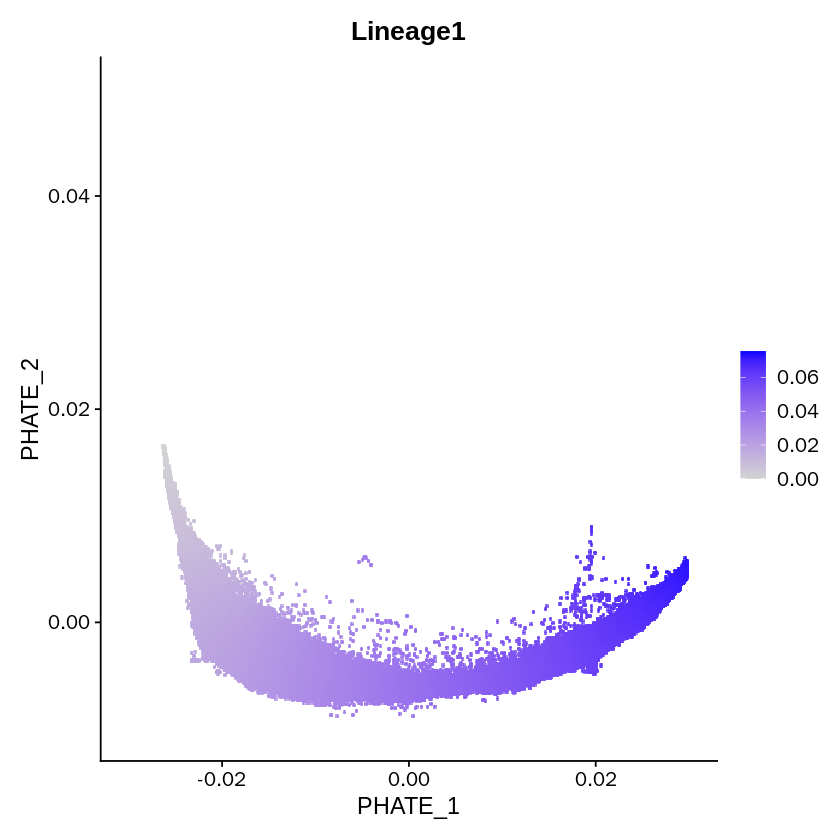

In [16]:
FeaturePlot(sdata, features = "Lineage1", reduction = "phate",pt.size = 1) + xlim(c(-0.03,0.03)) + ylim(c(-0.01,0.05))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 1673 rows containing missing values (geom_scattermore).”


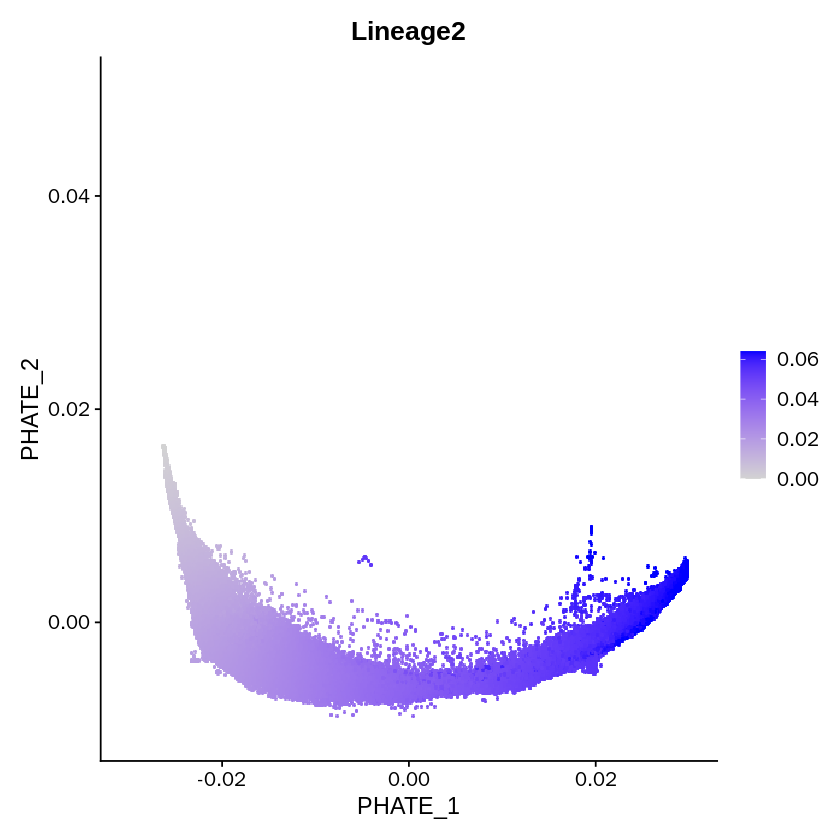

In [17]:
FeaturePlot(sdata, features = "Lineage2", reduction = "phate",pt.size = 1) + xlim(c(-0.03,0.03)) + ylim(c(-0.01,0.05))

### Choose one Lineage to use for Dynamic eQTL analysis

In [18]:
sdata@meta.data["DynamicLineage"] <- sdata@meta.data$Lineage1

# Calculate Quantile

Determines how many quantiles to divide the cell into. Divide by 6 in this case.

In [19]:
quantileNum <- 6

In [22]:
quantile(sdata@meta.data$DynamicLineage, probs=seq(0,1,length=quantileNum+1), type=4)

0%  16.66667%  33.33333%        50%  66.66667%  83.33333%       100% 
0.00000000 0.01675700 0.02006426 0.02505573 0.04801343 0.06726043 0.07553964

In [23]:
# Add Quantile number to each cell in Metadata
for ( num in 1:6 ) {
    print(num)
    sdata@meta.data[sdata@meta.data["DynamicLineage"] < quantile(sdata@meta.data["DynamicLineage"][,1], probs=seq(0,1,length=quantileNum+1), type=4)[quantileNum+2-num],"DynamicLineage_Quantile"] <- paste0(quantileNum+1-num)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6


In [24]:
sum(is.na(sdata@meta.data$Lineage1_Quantile == "NA"))

[1] 0

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



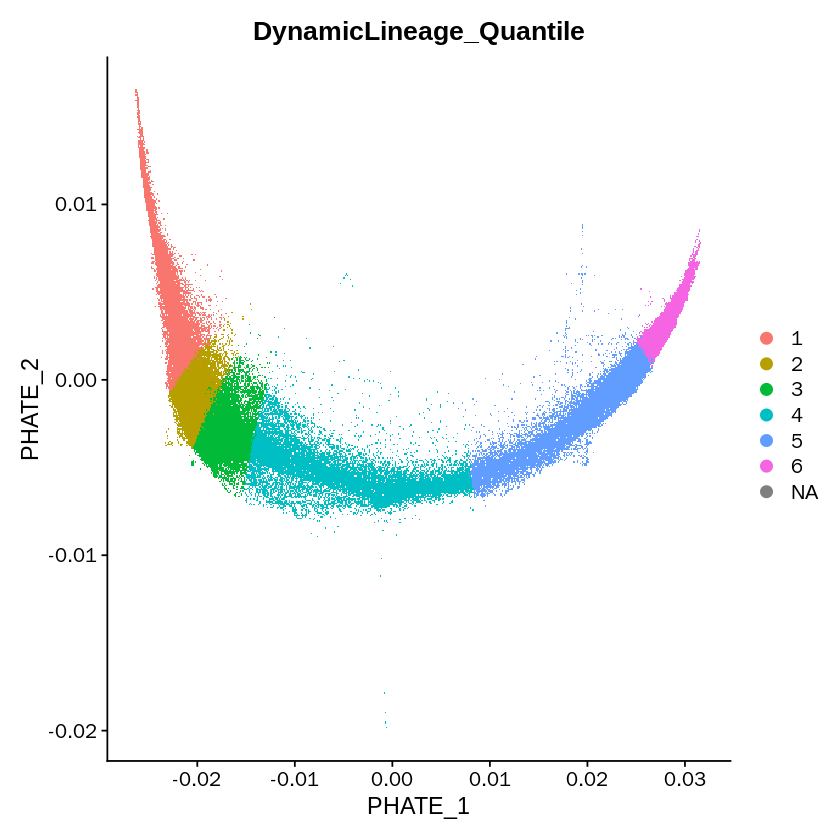

In [26]:
DimPlot(sdata, reduction = "phate", group.by = "DynamicLineage_Quantile")

# Save Seurat Object

In [27]:
# saveRDS(sdata,"/mnt/gmi-analysis01/_90.User_Data/juhyunk/project/sceQTL/dynamiceQTL/basal-sec/40.NRFonly.n11.basal.to.sec.slingshot.RDS")

In [28]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/_90.User_Data/juhyunk/anaconda3/envs/scRNA_R/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=ko_KR.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ko_KR.UTF-8        LC_COLLATE=ko_KR.UTF-8    
 [5] LC_MONETARY=ko_KR.UTF-8    LC_MESSAGES=ko_KR.UTF-8   
 [7] LC_PAPER=ko_KR.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ko_KR.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SeuratDisk_0.0.0.9020       tradeSeq_1.8.0             
 [3] sp_1.4-7                    SeuratObject_4.1.0         
 [5] Seurat_4.1.1                slingshot_2.3.1            
 [7] TrajectoryUtils_1.2.0       SingleCellExperiment_1.16.0
 [9] SummarizedExperiment_1.